In [1]:
import torch
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import scipy.io
import numpy as np

# Load the .mat file
file_path = '/Users/rohitviswam/Desktop/IITM Mat file/EV_Rank_1_52_RBs_50_UEs_1000_snaps.mat'
data = scipy.io.loadmat(file_path)

# Inspect the structure of the loaded data
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'EV_re_im_split'])

In [3]:
# Extract the relevant data
EV_data = data['EV_re_im_split']

# Check the shape and structure of the extracted data
print(EV_data.shape)

(50, 1000, 832)


In [4]:
data = EV_data

In [5]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [6]:
data_flattened = data.reshape(data.shape[0], -1)  # shape becomes (2100, 398*256)


In [7]:
data = data_flattened

In [8]:
data.shape

(50, 832000)

In [9]:
# Parameters
n_samples = 50
n_timesteps = 832000
input_window = 10  # First 10 values are used as input
output_window = 4  # Next 4 values are predicted
test_size = 0.2  # 20% of the data is used for testing

# Initialize lists to hold models and predictions/actuals for each UE
models = []
predictions = []
actuals = []

In [10]:
for ue in range(n_samples):
    # Extract data for this specific UE
    ue_data = data[ue, :]  # Shape: (n_timesteps,)
    
    # Create input-output pairs (input sequences and targets)
    X_ue = []
    y_ue = []
    
    for i in range(0, len(ue_data) - input_window - output_window + 1, input_window):
        # Use the current window for input
        X_ue.append(ue_data[i:i + input_window])
        # Predict the next 4 values immediately following the current window
        y_ue.append(ue_data[i + input_window:i + input_window + output_window])

    # Convert to NumPy arrays
    X_ue = np.array(X_ue)
    y_ue = np.array(y_ue)
    
    # Flatten the target array to make it compatible with XGBoost
    y_ue = y_ue.reshape((y_ue.shape[0], -1))  # (n_samples, output_window)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_ue, y_ue, test_size=test_size, random_state=42)

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, objective='reg:squarederror')
    
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = model.predict(X_test)
    
    # Save the predictions and actuals for evaluation
    predictions.append(y_pred)
    actuals.append(y_test)
    
    # Save the model for this UE
    models.append(model)

In [11]:
import pandas as pd

# Initialize a list to store DataFrames for each UE
all_results = []

# Iterate through the predictions and actuals stored previously
for ue_index, (y_pred, y_test) in enumerate(zip(predictions, actuals)):
    # Reshape predictions and actuals for ease of comparison
    y_pred_reshaped = y_pred.reshape(-1, output_window)
    y_test_reshaped = y_test.reshape(-1, output_window)
    
    # Create a DataFrame for this UE's predictions and actuals
    results_df = pd.DataFrame({
        "Actual_1": y_test_reshaped[:, 0],
        "Actual_2": y_test_reshaped[:, 1],
        "Actual_3": y_test_reshaped[:, 2],
        "Actual_4": y_test_reshaped[:, 3],
        "Predicted_1": y_pred_reshaped[:, 0],
        "Predicted_2": y_pred_reshaped[:, 1],
        "Predicted_3": y_pred_reshaped[:, 2],
        "Predicted_4": y_pred_reshaped[:, 3]
    })
    
    # Add an identifier for each UE
    results_df["UE"] = f"UE_{ue_index + 1}"
    
    # Append to the list of DataFrames
    all_results.append(results_df)

# Concatenate all DataFrames into one
final_results = pd.concat(all_results, ignore_index=True)

# Display the combined table
print(final_results)


        Actual_1  Actual_2  Actual_3  Actual_4  Predicted_1  Predicted_2  \
0      -0.027407 -0.004317  0.053694  0.128760    -0.006125    -0.006285   
1       0.016183  0.200006 -0.045117 -0.097472     0.024785     0.207494   
2      -0.143247 -0.229390 -0.004813 -0.002269    -0.127119    -0.176152   
3      -0.017924 -0.244573 -0.013894 -0.060304    -0.015854    -0.228256   
4      -0.020073 -0.215009  0.013128 -0.160308    -0.012447    -0.208619   
...          ...       ...       ...       ...          ...          ...   
831995  0.011387 -0.048955 -0.177336  0.219787     0.021941    -0.043419   
831996 -0.134780  0.107827 -0.080596  0.142200    -0.124401     0.100720   
831997 -0.103610  0.090359 -0.120352  0.164294    -0.080755     0.074820   
831998  0.116382 -0.146308  0.104925 -0.003955     0.115537    -0.139342   
831999  0.006185  0.006507 -0.113930  0.131833     0.004158     0.016206   

        Predicted_3  Predicted_4     UE  
0          0.041151     0.076026   UE_1  
1  

In [12]:
import matplotlib.pyplot as plt

def visualize_ue_predictions(ue_index):
    """Visualize actual vs. predicted values for a specific UE."""
    if ue_index < 0 or ue_index >= len(predictions):
        raise ValueError("Invalid UE index")
    
    # Retrieve the actual and predicted values for the given UE index
    y_pred = predictions[ue_index]
    y_test = actuals[ue_index]

    # Prepare for visualization by creating indices
    num_predictions = y_test.shape[0]
    indices = range(num_predictions)

    plt.figure(figsize=(12, 6))
    
    # Plot each predicted value against its corresponding actual value
    for i in range(output_window):
        plt.plot(indices, y_test[:, i], marker='o', label=f'Actual_{i+1}')
        plt.plot(indices, y_pred[:, i], marker='x', linestyle='--', label=f'Predicted_{i+1}')
    
    plt.title(f"Actual vs. Predicted Values for UE {ue_index + 1}")
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()


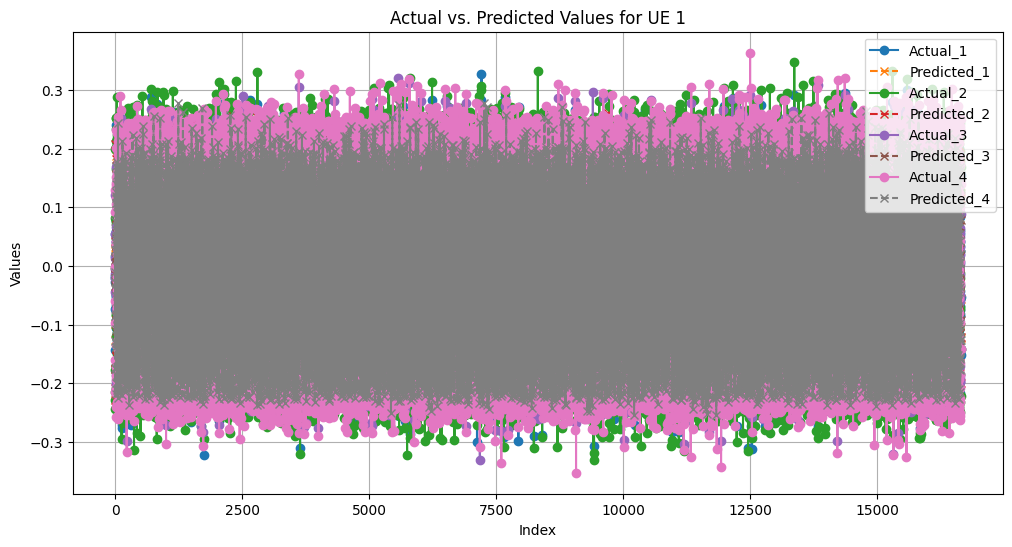

In [13]:
# Example usage: Visualize results for the first UE (index 0)
visualize_ue_predictions(0)

In [14]:
import matplotlib.pyplot as plt

def visualize_ue_predictions_with_range(ue_index, num_values):
    """Visualize actual vs. predicted values for a specific UE, limited to the first num_values entries."""
    if ue_index < 0 or ue_index >= len(predictions):
        raise ValueError("Invalid UE index")
    
    # Retrieve the actual and predicted values for the given UE index
    y_pred = predictions[ue_index]
    y_test = actuals[ue_index]

    # Ensure not to exceed the number of available predictions
    num_values = min(num_values, y_pred.shape[0])

    # Prepare for visualization by creating indices
    indices = range(num_values)

    plt.figure(figsize=(12, 6))
    
    # Plot each predicted value against its corresponding actual value for the first num_values
    for i in range(output_window):
        plt.plot(indices, y_test[:num_values, i], marker='o', label=f'Actual_{i+1}')
        plt.plot(indices, y_pred[:num_values, i], marker='x', linestyle='--', label=f'Predicted_{i+1}')
    
    plt.title(f"Actual vs. Predicted Values for UE {ue_index + 1} - First {num_values} Points")
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()



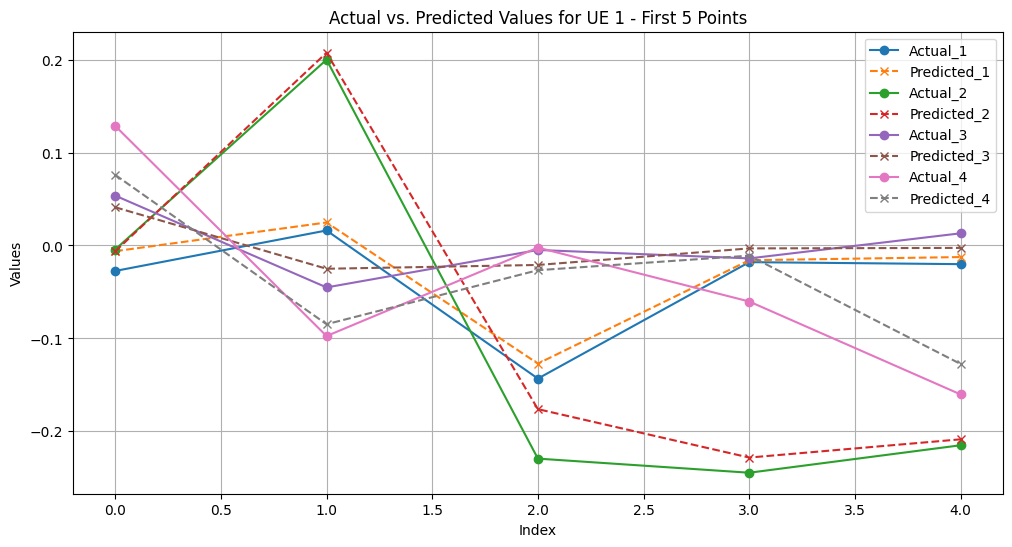

In [15]:
# Example usage: Visualize results for the first UE (index 0) and the first 20 data points
visualize_ue_predictions_with_range(0, 5)

In [16]:
# Optionally save to a CSV file for further analysis
# final_results.to_csv("ue_predictions_comparison-10->4.csv", index=False)

In [17]:
# Assuming X_test and y_test are your test datasets
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

RMSE:  0.07553312919980189


In [18]:
import numpy as np

# Assuming y contains your target variable values
min_value = np.min(y_ue)
max_value = np.max(y_ue)

print("Minimum Value:", min_value)
print("Maximum Value:", max_value)

Minimum Value: -0.34595729863655367
Maximum Value: 0.34618561189838903


In [19]:
accuracy = 100- (rmse /( max_value-min_value)) * 100

In [20]:
accuracy

89.08706163855324